# Check offset forcing for freshwater IAF simulation is correct

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
import shutil as shutil

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/freshwater_IAF/forcing/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38461/status,
Dashboard: /proxy/38461/status,Workers: 7
Total threads: 28,Total memory: 125.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36465,Workers: 7
Dashboard: /proxy/38461/status,Total threads: 28
Started: Just now,Total memory: 125.21 GiB
Comm: tcp://127.0.0.1:41637,Total threads: 4
Dashboard: /proxy/37353/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:33043,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

lat_slice  = slice(-90,-59)

In [4]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

fontsize=13

## Open data and check

In [5]:
# open saved data:
outpath = '/g/data/v45/akm157/model_data/access-om_input/01deg_jra55v140_iaf_cycle3_freshwater/friver_offset_19790101-20190105.nc'
saved_data = xr.open_dataset(outpath)
runoff_offset = saved_data.friver

In [7]:
# open FW forcing, so have correct JRA grid:
#runoff_file = '/g/data/x77/amh157/JRA55-do/RYF/v1-3/RYF.runoff_all.1990_1991.nc'

# note melt and calving are input separately. Need to add both contributions to get total:
runoff_file1 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/landIce/day/licalvf/gr/v20190429/licalvf_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_19580101-19581231.nc'
ds = xr.open_dataset(runoff_file1,decode_times=False)
# extract arrays from dataset:
runoff1 = ds.licalvf
runoff1 = runoff1.isel(time=0).drop('time').sel(lat=lat_slice)

runoff_file2 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/land/day/friver/gr/v20190429/friver_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_19580101-19581231.nc'
ds = xr.open_dataset(runoff_file2,decode_times=False)
# extract arrays from dataset:
runoff2 = ds.friver
runoff2 = runoff2.isel(time=0).drop('time').sel(lat=lat_slice)

runoff = runoff1 + runoff2
#plt.figure(figsize=(12,8))
#runoff.plot(vmin=0,vmax=1e-4,cmap=cmocean.amp)

# create region masks:
# David to Denman:
Wilkes_mask = runoff*0 + 1
Wilkes_mask = Wilkes_mask.where((runoff.lat>-76)&(runoff.lon>95)&(runoff.lon<180))

# Fox to Nickerson:
AB_mask = runoff*0 + 1
AB_mask = AB_mask.where((runoff.lon<360-80)&(runoff.lon>=360-146))

#Larsen C to Stange:
Peninsula_mask = runoff*0 + 1
Peninsula_mask = Peninsula_mask.where((runoff.lon<360-40)&(runoff.lon>=360-80))
Peninsula_mask = Peninsula_mask.where(~((runoff.lon>295)&(runoff.lat<-70)))

combined_mask = Wilkes_mask.fillna(0) + AB_mask.fillna(0)*2 + Peninsula_mask.fillna(0)*3
combined_mask = combined_mask.where(combined_mask>0)

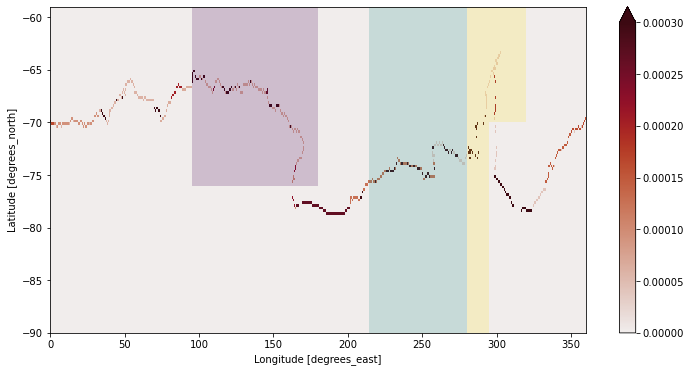

In [8]:
plt.figure(figsize=(12,6))
runoff.plot(cmap=cmocean.amp,vmax=3e-4)
plt.pcolormesh(combined_mask.lon,combined_mask.lat,combined_mask,alpha=0.2)

In [10]:
# need area on the JRA grid:
# data is 0.25 deg.
resolution=0.25
radius = 6376e3
dy = radius*(np.pi/180*resolution) + runoff.lat*0
dx = dy*np.cos(runoff.lat/180*np.pi)
area = dy*dx

# conversion to Gt/yr:
conversion_factor = 60*60*24*365.25/1e12
# to convert to Sv:
#conversion_factor = (1e-3)*(1e-6)

# check whole Antarctic runoff, should be close to 2775 Gt/y (Depoorter). Also it matches 0.0876 Sv stated in Tsujino et al. 2018:
Antarctica_runoff = (runoff*area).sum('lon').sum('lat')*conversion_factor
# Antarctica_runoff = 2764 Gt/y

Wilkes_runoff = (runoff*Wilkes_mask*area).sum('lon').sum('lat')*conversion_factor
# Wilkes_runoff = 587.3 Gt/y

AB_runoff = (runoff*AB_mask*area).sum('lon').sum('lat')*conversion_factor
# AB_runoff = 812.2 Gt/y

Peninsula_runoff = (runoff*Peninsula_mask*area).sum('lon').sum('lat')*conversion_factor
# Peninsula_runoff = 243.6 Gt/y

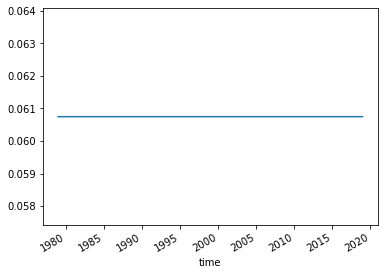

In [13]:
East_Ant_timeseries = (runoff_offset*Wilkes_mask*area).sum('lon').sum('lat')*conversion_factor/Wilkes_runoff
East_Ant_timeseries.plot()

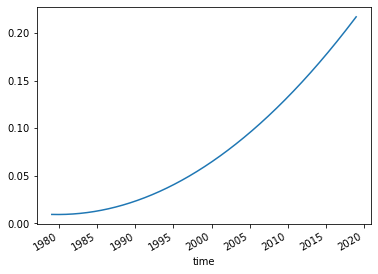

In [14]:
West_Ant_timeseries = (runoff_offset*AB_mask*area).sum('lon').sum('lat')*conversion_factor/AB_runoff
West_Ant_timeseries.plot()

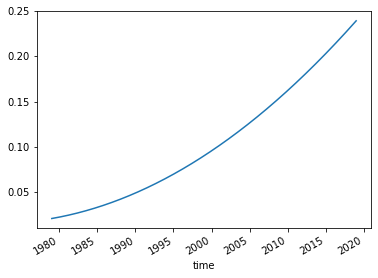

In [15]:
Pen_timeseries = (runoff_offset*Peninsula_mask*area).sum('lon').sum('lat')*conversion_factor/Peninsula_runoff
Pen_timeseries.plot()